In [86]:
import spotipy
from matplotlib import pyplot as plt
from spotipy.oauth2 import SpotifyOAuth, SpotifyClientCredentials
import urllib
import spotipy.util as util
import numpy as np
import cv2
import json
import requests
import pandas as pd
from IPython.display import Image, display
from sklearn.cluster import KMeans

from datetime import datetime


In [87]:
# Spotify Credentials Setup
credentials = "spotify_keys.json"
with open(credentials, "r") as keys:
    api_tokens = json.load(keys)

client_id = api_tokens["client_id"]
client_secret = api_tokens["client_secret"]
redirectURI = api_tokens["redirect"]
username = api_tokens["username"]

In [88]:
# Set up Spotify Client with required scope for top tracks
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri="YOUR_REDIRECT_URI",
                                               scope="user-top-read"))

In [89]:
# shopstyle Setup
with open('shopstyle_api.txt','r') as shop_file:
    shopstyle_key = shop_file.read()

In [90]:
# Function to download the album image and convert it to a color format usable by OpenCV
def url_to_image(url):
# download the image, convert it to a Numpy array, then reverse it into OpenCV formate
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image


In [91]:
# Function to create a histogram of colors in the image
def find_histogram(clt):
    """
    create a histogram with k clusters
    :param: clt
    :return:hist
    """
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    hist = hist.astype("float")
    hist /= hist.sum()

    return hist

In [77]:
# Function to plot the top colors
def plot_colors2(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        # plot the realtive percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0),(int(endX), 50),
                     color.astype("uint8").tolist(), -1)
        startX = endX

    # return the car chart
    return bar

In [78]:
# Function to get album colors from Spotify song
def get_album_colors(track_name):
    results = sp.search(q=track_name, limit=1)
    if not results['tracks']['items']:
        print("No track found.")
        return None
    album_image_url = results['tracks']['items'][0]['album']['images'][0]['url']
    image = url_to_image(album_image_url)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    clt = KMeans(n_clusters=3)  # Cluster for top 3 colors
    clt.fit(image)
    hist = find_histogram(clt)
    bar = plot_colors2(hist, clt.cluster_centers_)
    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    return [tuple(map(int, color)) for color in clt.cluster_centers_]

In [79]:
# Function to convert RGB to color names (roughly)
def rgb_to_color_name(rgb):
    r, g, b = rgb
    if r > 200 and g > 200 and b < 100:
        return "yellow"
    elif r < 100 and g > 200 and b > 200:
        return "cyan"
    elif r > 200 and g < 100 and b < 100:
        return "red"
    elif r < 100 and g < 100 and b > 200:
        return "blue"
    elif r > 200 and g > 100 and b < 100:
        return "orange"
    elif r < 100 and g > 100 and b < 100:
        return "green"
    else:
        return "neutral"

In [80]:
# Determine the current season based on month
def get_current_season():
    month = datetime.now().month
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "fall"

In [81]:
# ShopStyle API call to get outfit suggestions based on color, gender and season
def get_outfit_suggestions(color_name, gender, season, keyword="clothing", limit=5):
    url = f"https://api.shopstyle.com/api/v2/products"
    params = {
        "pid": shopstyle_key,
        "fts": f"{gender} {keyword} {color_name}",  # Filter by gender, keyword, and color
        "offset": 0,
        "limit": limit,
        "sort": "popularity"  # Optionally sort by popularity
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json().get("products", [])
    else:
        print("Error fetching outfits:", response.status_code)
        return []

In [82]:

# Display fetched outfit suggestions with inline images in Jupyter
def display_outfits(outfits, color_name):
    if outfits:
        print(f"Outfits for Color {color_name.capitalize()}:")
        for item in outfits:
            title = item.get("name")
            price = item.get("priceLabel")
            brand = item.get("brand", {}).get("name")
            link = item.get("clickUrl")

             # Check if "image" is a dictionary, and extract the actual URL string
            image_data = item.get("image", "")
            image_url = image_data.get("sizes", {}).get("Original", {}).get("url") if isinstance(image_data, dict) else image_data
            
            # Display outfit details
            print(f"Title: {title}")
            print(f"Price: {price}")
            print(f"Brand: {brand}")
            print(f"Link: {link}")
            
            # Display image inline if image_url is available and is a string
            if isinstance(image_url, str) and image_url:
                display(Image(url=image_url))
            
            print("\n" + "-"*50 + "\n")  # Divider between items
    else:
        print(f"No outfits found for color {color_name}")

In [83]:
# Fetch top 3 tracks and generate outfits based on each song’s album color
def generate_music_inspired_outfit_recommendations(gender):
    # Fetch user's top 3 tracks
    results = sp.current_user_top_tracks(limit=3)
    top_tracks = results['items']
    
    # Determine current season
    season = get_current_season()
    
    for track in top_tracks:
        track_name = track['name']
        artist_name = track['artists'][0]['name']
        album_image_url = track['album']['images'][0]['url']
        
        print(f"\nGenerating outfit for '{track_name}' by {artist_name}")
        colors = get_album_colors(album_image_url)
        color_names = [rgb_to_color_name(color) for color in colors]

      # Generate outfit recommendations for each color in the album art
        for color_name in color_names:
            outfits = get_outfit_suggestions(color_name, gender, season)
            display_outfits(outfits, color_name)

    


Generating outfit for 'Overcast' by Kevin MacLeod


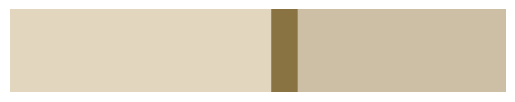

Error fetching outfits: 403
No outfits found for color neutral
Error fetching outfits: 403
No outfits found for color neutral
Error fetching outfits: 403
No outfits found for color neutral

Generating outfit for 'Story of My Life' by One Direction


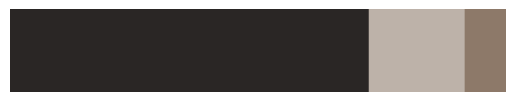

Error fetching outfits: 403
No outfits found for color neutral
Error fetching outfits: 403
No outfits found for color neutral
Error fetching outfits: 403
No outfits found for color neutral

Generating outfit for 'Night Changes' by One Direction


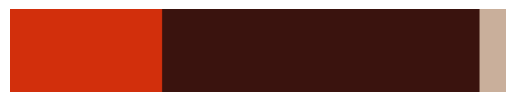

Error fetching outfits: 403
No outfits found for color red
Error fetching outfits: 403
No outfits found for color neutral
Error fetching outfits: 403
No outfits found for color neutral


In [84]:
# Run the function with an example track and specified gender
generate_music_inspired_outfit_recommendations("women")  # Change "men" to "women" as needed